In [1]:
import torch
import utilities

device = ("cuda" if torch.cuda.is_available() else "cpu")
# device = "cpu"

In [2]:
data_main = utilities.pre_processing_base(
    csv="../data/SIDI_Full.csv",
    device=device,
    split=0.8,
    target_var="DI",
)

In [3]:
data_main[100]

(array([  4.,   1., -15.,  15.], dtype=float32), 0.40649)

In [4]:
data_ft = utilities.pre_processing_ft(data_main, device)
data_t = utilities.pre_processing_t(data_main, device)
data_f = utilities.pre_processing_f(data_main, device)
data_none = utilities.pre_processing_none(data_main, device)

In [5]:
losses = {
    "data_none": [],
    "data_ft": [],
    "data_f": [],
    "data_t": [],
}

In [6]:
import math
import rtdl
import delu

config = {
    "learning_rate": 0.0003,
    "epochs": 1000,
    "batch_size": 32,
    "dropout": 0.2,
    "train_split": 0.8,
    "weight_decay": 0.0,
    "patience": 20
}

data = data_f
model = rtdl.MLP.make_baseline(
    d_in=data.X['train'].shape[1],
    d_layers=[64,64],
    dropout=config['dropout'],
    d_out=1,
)

model.to(device)
optimizer = (
    torch.optim.AdamW(model.parameters(),
    lr=config['learning_rate'],
    weight_decay=config['weight_decay'])
)
loss_fn = torch.nn.MSELoss()

@torch.no_grad()
def evaluate(part):
    model.eval()
    pred = model(data.X[part]).squeeze(1)
    target = data.y[part]
    score = loss_fn(pred, target)
    return {
        "score": score,
        "pred": pred,
        "target": target
    }

# Create a dataloader for batches of indices
batch_size = config['batch_size']
train_loader = delu.data.make_index_dataloader(len(data.X['train']), config['batch_size'])

# Create a progress tracker for early stopping
progress = delu.ProgressTracker(config['patience'])
print(f'Test score before training: {evaluate("test")["score"]:.4f}')

n_epochs = config['epochs']
for epoch in range(n_epochs):
    for iteration, batch_idx in enumerate(train_loader):
        model.train()
        optimizer.zero_grad()
        x_batch = data.X['train'][batch_idx]
        y_batch = data.y['train'][batch_idx]
        loss = loss_fn(model(x_batch).squeeze(1), y_batch)
        loss.backward()
        optimizer.step()

    val_score = evaluate('val')
    test_score = evaluate('test')

    valid_rmse = math.sqrt(val_score['score'].cpu().numpy())
    test_rmse = math.sqrt(test_score['score'].cpu().numpy())

    losses['data_f'].append(test_rmse)

    print(f'Epoch {epoch:03d} | Validation score: {val_score["score"]:.4f} | Test score: {test_score["score"]:.4f}', end='')
    progress.update((-1) * val_score["score"])
    if progress.success:
        print(' <<< BEST VALIDATION EPOCH', end='')
    print()
    if progress.fail:
        break

torch.save(model, f"../models/model_data_f.pth")

/home/color/miniconda3/envs/hvis_rtdl/lib/python3.10/site-packages/delu/_utils.py:14: DeLUDeprecationWarning: The function make_index_dataloader` is deprecated and will be removed in future releases. Instead, use `delu.data.IndexDataset` and `~torch.utils.data.DataLoader`
  warnings.warn(


Test score before training: 0.2183
Epoch 000 | Validation score: 0.0797 | Test score: 0.0708 <<< BEST VALIDATION EPOCH
Epoch 001 | Validation score: 0.0558 | Test score: 0.0497 <<< BEST VALIDATION EPOCH
Epoch 002 | Validation score: 0.0359 | Test score: 0.0336 <<< BEST VALIDATION EPOCH
Epoch 003 | Validation score: 0.0199 | Test score: 0.0206 <<< BEST VALIDATION EPOCH
Epoch 004 | Validation score: 0.0116 | Test score: 0.0133 <<< BEST VALIDATION EPOCH
Epoch 005 | Validation score: 0.0084 | Test score: 0.0105 <<< BEST VALIDATION EPOCH
Epoch 006 | Validation score: 0.0074 | Test score: 0.0093 <<< BEST VALIDATION EPOCH
Epoch 007 | Validation score: 0.0069 | Test score: 0.0087 <<< BEST VALIDATION EPOCH
Epoch 008 | Validation score: 0.0059 | Test score: 0.0080 <<< BEST VALIDATION EPOCH
Epoch 009 | Validation score: 0.0054 | Test score: 0.0075 <<< BEST VALIDATION EPOCH
Epoch 010 | Validation score: 0.0053 | Test score: 0.0071 <<< BEST VALIDATION EPOCH
Epoch 011 | Validation score: 0.0048 | Te

In [7]:
inputs_tensors = data_f.X['test'][10:20]
reals = data_f.y['test'][10:20]

In [8]:
model = torch.load("../models/model_data_f.pth")
results = []
for v in inputs_tensors:
    input_tensor = v.to(device)
    model.eval()
    with torch.no_grad():
        result = model(input_tensor)
        results.append(result)

print(f"predicted values are: \n{results}")

predicted values are: 
[tensor([0.6337], device='cuda:0'), tensor([-0.0006], device='cuda:0'), tensor([0.2738], device='cuda:0'), tensor([0.1410], device='cuda:0'), tensor([0.1949], device='cuda:0'), tensor([1.0125], device='cuda:0'), tensor([0.5771], device='cuda:0'), tensor([0.6638], device='cuda:0'), tensor([0.0044], device='cuda:0'), tensor([0.5360], device='cuda:0')]


In [9]:
data = data_t
model = rtdl.MLP.make_baseline(
    d_in=data.X['train'].shape[1],
    d_layers=[64,64],
    dropout=config['dropout'],
    d_out=1,
)

model.to(device)
optimizer = (
    torch.optim.AdamW(model.parameters(),
    lr=config['learning_rate'],
    weight_decay=config['weight_decay'])
)
loss_fn = torch.nn.MSELoss()

@torch.no_grad()
def evaluate(part):
    model.eval()
    pred = model(data.X[part]).squeeze(1)
    target = data.y[part]
    score = loss_fn(pred, target)
    return {
        "score": score,
        "pred": pred,
        "target": target
    }

# Create a dataloader for batches of indices
batch_size = config['batch_size']
train_loader = delu.data.make_index_dataloader(len(data.X['train']), config['batch_size'])

# Create a progress tracker for early stopping
progress = delu.ProgressTracker(config['patience'])
print(f'Test score before training: {evaluate("test")["score"]:.4f}')

n_epochs = config['epochs']
for epoch in range(n_epochs):
    for iteration, batch_idx in enumerate(train_loader):
        model.train()
        optimizer.zero_grad()
        x_batch = data.X['train'][batch_idx]
        y_batch = data.y['train'][batch_idx]
        loss = loss_fn(model(x_batch).squeeze(1), y_batch)
        loss.backward()
        optimizer.step()

    val_score = evaluate('val')
    test_score = evaluate('test')

    valid_rmse = math.sqrt(val_score['score'].cpu().numpy())
    test_rmse = math.sqrt(test_score['score'].cpu().numpy())

    losses['data_t'].append(test_rmse)

    print(f'Epoch {epoch:03d} | Validation score: {val_score["score"]:.4f} | Test score: {test_score["score"]:.4f}', end='')
    progress.update((-1) * val_score["score"])
    if progress.success:
        print(' <<< BEST VALIDATION EPOCH', end='')
    print()
    if progress.fail:
        break

torch.save(model, f"../models/model_data_t.pth")

Test score before training: 6.0951
Epoch 000 | Validation score: 1.3067 | Test score: 1.0465 <<< BEST VALIDATION EPOCH
Epoch 001 | Validation score: 1.0869 | Test score: 0.9552 <<< BEST VALIDATION EPOCH
Epoch 002 | Validation score: 0.8860 | Test score: 0.8158 <<< BEST VALIDATION EPOCH
Epoch 003 | Validation score: 0.8619 | Test score: 0.8399 <<< BEST VALIDATION EPOCH
Epoch 004 | Validation score: 0.9679 | Test score: 0.9216
Epoch 005 | Validation score: 0.9345 | Test score: 0.8337
Epoch 006 | Validation score: 0.8318 | Test score: 0.7821 <<< BEST VALIDATION EPOCH
Epoch 007 | Validation score: 0.8205 | Test score: 0.7826 <<< BEST VALIDATION EPOCH
Epoch 008 | Validation score: 0.8071 | Test score: 0.7753 <<< BEST VALIDATION EPOCH
Epoch 009 | Validation score: 0.7977 | Test score: 0.7771 <<< BEST VALIDATION EPOCH
Epoch 010 | Validation score: 0.7926 | Test score: 0.7634 <<< BEST VALIDATION EPOCH
Epoch 011 | Validation score: 0.8123 | Test score: 0.7616
Epoch 012 | Validation score: 0.804

In [10]:
data = data_ft
model = rtdl.MLP.make_baseline(
    d_in=data.X['train'].shape[1],
    d_layers=[64,64],
    dropout=config['dropout'],
    d_out=1,
)

model.to(device)
optimizer = (
    torch.optim.AdamW(model.parameters(),
    lr=config['learning_rate'],
    weight_decay=config['weight_decay'])
)
loss_fn = torch.nn.MSELoss()

@torch.no_grad()
def evaluate(part):
    model.eval()
    pred = model(data.X[part]).squeeze(1)
    target = data.y[part]
    score = loss_fn(pred, target)
    return {
        "score": score,
        "pred": pred,
        "target": target
    }

# Create a dataloader for batches of indices
batch_size = config['batch_size']
train_loader = delu.data.make_index_dataloader(len(data.X['train']), config['batch_size'])

# Create a progress tracker for early stopping
progress = delu.ProgressTracker(config['patience'])
print(f'Test score before training: {evaluate("test")["score"]:.4f}')

n_epochs = config['epochs']
for epoch in range(n_epochs):
    for iteration, batch_idx in enumerate(train_loader):
        model.train()
        optimizer.zero_grad()
        x_batch = data.X['train'][batch_idx]
        y_batch = data.y['train'][batch_idx]
        loss = loss_fn(model(x_batch).squeeze(1), y_batch)
        loss.backward()
        optimizer.step()

    val_score = evaluate('val')
    test_score = evaluate('test')

    valid_rmse = math.sqrt(val_score['score'].cpu().numpy())
    test_rmse = math.sqrt(test_score['score'].cpu().numpy())

    losses['data_ft'].append(test_rmse)

    print(f'Epoch {epoch:03d} | Validation score: {val_score["score"]:.4f} | Test score: {test_score["score"]:.4f}', end='')
    progress.update((-1) * val_score["score"])
    if progress.success:
        print(' <<< BEST VALIDATION EPOCH', end='')
    print()
    if progress.fail:
        break

torch.save(model, f"../models/model_data_ft.pth")

Test score before training: 0.8506
Epoch 000 | Validation score: 0.8820 | Test score: 0.7708 <<< BEST VALIDATION EPOCH
Epoch 001 | Validation score: 0.7898 | Test score: 0.6943 <<< BEST VALIDATION EPOCH
Epoch 002 | Validation score: 0.6729 | Test score: 0.5995 <<< BEST VALIDATION EPOCH
Epoch 003 | Validation score: 0.5114 | Test score: 0.4680 <<< BEST VALIDATION EPOCH
Epoch 004 | Validation score: 0.3392 | Test score: 0.3268 <<< BEST VALIDATION EPOCH
Epoch 005 | Validation score: 0.1947 | Test score: 0.2067 <<< BEST VALIDATION EPOCH
Epoch 006 | Validation score: 0.1122 | Test score: 0.1364 <<< BEST VALIDATION EPOCH
Epoch 007 | Validation score: 0.0772 | Test score: 0.1023 <<< BEST VALIDATION EPOCH
Epoch 008 | Validation score: 0.0683 | Test score: 0.0966 <<< BEST VALIDATION EPOCH
Epoch 009 | Validation score: 0.0611 | Test score: 0.0870 <<< BEST VALIDATION EPOCH
Epoch 010 | Validation score: 0.0568 | Test score: 0.0822 <<< BEST VALIDATION EPOCH
Epoch 011 | Validation score: 0.0524 | Te

In [11]:
data = data_none
model = rtdl.MLP.make_baseline(
    d_in=data.X['train'].shape[1],
    d_layers=[64,64],
    dropout=config['dropout'],
    d_out=1,
)

model.to(device)
optimizer = (
    torch.optim.AdamW(model.parameters(),
    lr=config['learning_rate'],
    weight_decay=config['weight_decay'])
)
loss_fn = torch.nn.MSELoss()

@torch.no_grad()
def evaluate(part):
    model.eval()
    pred = model(data.X[part]).squeeze(1)
    target = data.y[part]
    score = loss_fn(pred, target)
    return {
        "score": score,
        "pred": pred,
        "target": target
    }

# Create a dataloader for batches of indices
batch_size = config['batch_size']
train_loader = delu.data.make_index_dataloader(len(data.X['train']), config['batch_size'])

# Create a progress tracker for early stopping
progress = delu.ProgressTracker(config['patience'])
print(f'Test score before training: {evaluate("test")["score"]:.4f}')

n_epochs = config['epochs']
for epoch in range(n_epochs):
    for iteration, batch_idx in enumerate(train_loader):
        model.train()
        optimizer.zero_grad()
        x_batch = data.X['train'][batch_idx]
        y_batch = data.y['train'][batch_idx]
        loss = loss_fn(model(x_batch).squeeze(1), y_batch)
        loss.backward()
        optimizer.step()

    val_score = evaluate('val')
    test_score = evaluate('test')

    valid_rmse = math.sqrt(val_score['score'].cpu().numpy())
    test_rmse = math.sqrt(test_score['score'].cpu().numpy())

    losses['data_none'].append(test_rmse)

    print(f'Epoch {epoch:03d} | Validation score: {val_score["score"]:.4f} | Test score: {test_score["score"]:.4f}', end='')
    progress.update((-1) * val_score["score"])
    if progress.success:
        print(' <<< BEST VALIDATION EPOCH', end='')
    print()
    if progress.fail:
        break

torch.save(model, f"../models/model_data_none.pth")

Test score before training: 2.6128
Epoch 000 | Validation score: 0.9524 | Test score: 0.8712 <<< BEST VALIDATION EPOCH
Epoch 001 | Validation score: 0.5129 | Test score: 0.5166 <<< BEST VALIDATION EPOCH
Epoch 002 | Validation score: 0.3948 | Test score: 0.3992 <<< BEST VALIDATION EPOCH
Epoch 003 | Validation score: 0.2232 | Test score: 0.2298 <<< BEST VALIDATION EPOCH
Epoch 004 | Validation score: 0.1916 | Test score: 0.2047 <<< BEST VALIDATION EPOCH
Epoch 005 | Validation score: 0.2383 | Test score: 0.2542
Epoch 006 | Validation score: 0.2130 | Test score: 0.2242
Epoch 007 | Validation score: 0.1441 | Test score: 0.1483 <<< BEST VALIDATION EPOCH
Epoch 008 | Validation score: 0.1842 | Test score: 0.1921
Epoch 009 | Validation score: 0.1580 | Test score: 0.1692
Epoch 010 | Validation score: 0.1741 | Test score: 0.1807
Epoch 011 | Validation score: 0.1717 | Test score: 0.1775
Epoch 012 | Validation score: 0.1531 | Test score: 0.1586
Epoch 013 | Validation score: 0.1382 | Test score: 0.14

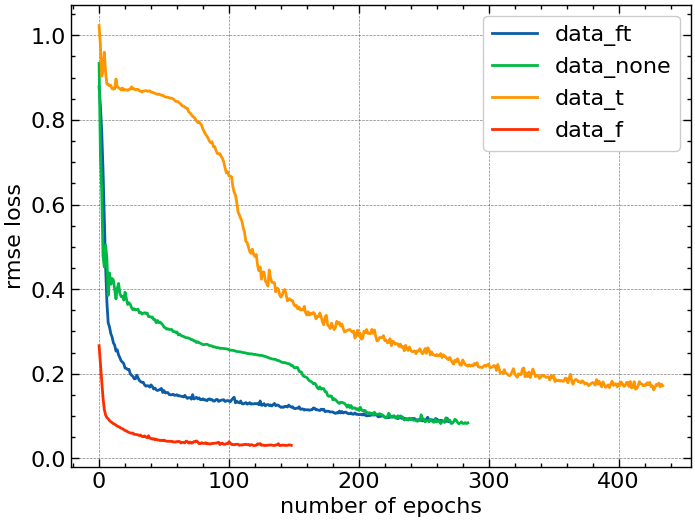

In [12]:
import matplotlib.pyplot as plt
import scienceplots

plt.style.use(['science', 'notebook', 'grid'])
# plt.style.use(['default'])
plt.plot(losses['data_ft'], label='data_ft')
plt.plot(losses['data_none'], label='data_none')
plt.plot(losses['data_t'], label='data_t')
plt.plot(losses['data_f'], label='data_f')
plt.xlabel('number of epochs')
plt.ylabel('rmse loss')
plt.legend()
plt.savefig("../figures/pp_impact.pdf")
plt.show()